In [31]:
import numpy as np
import pandas as pd
import sklearn

import os
import sys
from tqdm import tqdm_notebook
import tensorflow as tf
import tensorflow_hub as hub
from nltk import sent_tokenize
import matplotlib.pyplot as plt
import pickle
import math
import keras
import nltk

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Loading the dataset 
df = pd.read_csv("Text_Similarity_Dataset.csv")

In [3]:
df.head()

,Unique_ID,text1,text2
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...
1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...
2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...
3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...
4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023 entries, 0 to 4022
Data columns (total 3 columns):
Unique_ID    4023 non-null int64
text1        4023 non-null object
text2        4023 non-null object
dtypes: int64(1), object(2)
memory usage: 94.4+ KB


In [ ]:
#So in our Dataset, there are 4023 observation i.e. 4023 pairs of paragraphs

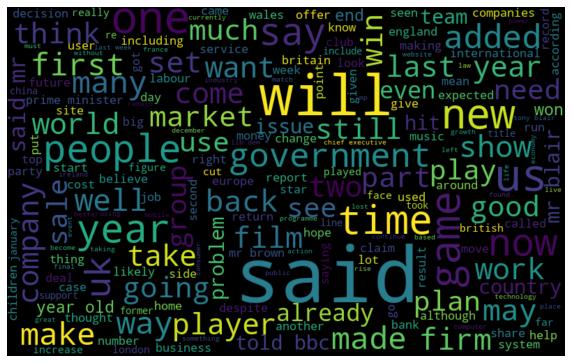

In [48]:
#visualize all the words our data using the wordcloud plot.

all_words = ' '.join([text for text in df['text1']])

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

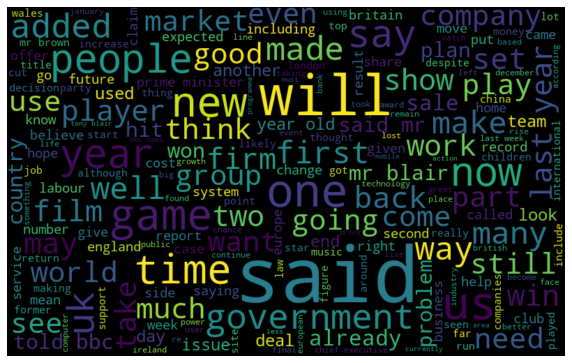

In [49]:
#visualize all the words our data using the wordcloud plot.

all_words = ' '.join([text for text in df['text2']])

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [32]:
#Preprocessing Data: Cleaning text and removing unwanted words and symbols

import re
def clean_paragraph(text_list):
    clean_list = []
    for sent in text_list:
        sent = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-.:;<=>?@[\]^`{|}~"""), '',sent)
        sent = sent.replace('[]','')
        sent = re.sub('\d+',' ',sent)
        sent = sent.lower()
        sent = re.sub(r"what's", "what is ", sent)
        sent = re.sub(r"\'s", " ", sent)
        sent = re.sub(r"\'ve", " have ", sent)
        sent = re.sub(r"can't", "cannot ", sent)
        sent = re.sub(r"n't", " not ", sent)
        sent = re.sub(r"i'm", "i am ", sent)
        sent = re.sub(r"\'re", " are ", sent)
        sent = re.sub(r"\'d", " would ", sent)
        sent = re.sub(r"\'ll", " will ", sent)
        sent = re.sub(r",", " ", sent)
        sent = re.sub(r"\.", " ", sent)
        sent = re.sub(r"!", " ! ", sent)
        sent = re.sub(r"\/", " ", sent)
        sent = re.sub(r"\^", " ^ ", sent)
        sent = re.sub(r"\+", " + ", sent)
        sent = re.sub(r"\-", " - ", sent)
        sent = re.sub(r"\=", " = ", sent)
        sent = re.sub(r"'", " ", sent)
        sent = re.sub(r"(\d+)(k)", r"\g<1>000", sent)
        sent = re.sub(r":", " : ", sent)
        sent = re.sub(r" e g ", " eg ", sent)
        sent = re.sub(r" b g ", " bg ", sent)
        sent = re.sub(r" u s ", " american ", sent)
        sent = re.sub(r"\0s", "0", sent)
        sent = re.sub(r" 9 11 ", "911", sent)
        sent = re.sub(r"e - mail", "email", sent)
        sent = re.sub(r"j k", "jk", sent)
        sent = re.sub(r"\s{2,}", " ", sent)
        sent = sent.split()
        clean_list.append(sent)
    return clean_list

In [ ]:
#Embedding using Google universal encoder

In [11]:
# Embedding using Google universal encoder
# we use Sentence encoding as many sentences are similar in textual context

nltk.download("punkt")
X=[]
with tf.Graph().as_default():
    #loading model
    embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
    print("embed",embed)
    messages = tf.compat.v1.placeholder(dtype=tf.string, shape=[None])
    output = embed(messages)
    #tensorflow session
    with tf.compat.v1.Session() as session:
        session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
        for text in ["text1","text2"]:
            phrases_emb_list = []
            for phrases in tqdm_notebook(df[text]):
                #breaking paragraph into sentences  
                sent_list = sent_tokenize(phrases)
                #cleaning the sentence
                clean_sent_list = clean_paragraph(sent_list)
                #feeding sentence in the encoder
                sent_embed = session.run(output, feed_dict={messages: clean_sent_list})
                #appending the encodings in a list
                phrases_emb_list.append(sent_embed.mean(axis=0).reshape(1,512))
            X.append(phrases_emb_list)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


embed <tensorflow_hub.module.Module object at 0x0000006482F01470>
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
# saving the encodings for future use

encodings = open("enc.pkl", "wb")
pickle.dump(X, encodings)
encodings.close()

In [13]:
# Converting the encoding into numpy arrays

text1 = np.array(X[0])
text2 = np.array(X[1])

In [27]:
print(text1.shape)
print(text2.shape)

(4023, 1, 512)
(4023, 1, 512)


In [16]:
#converting data to numpy aaray
X_data = np.array(X)

In [ ]:
#Cosine Similarity

In [18]:
def get_cosine(vec1, vec2):
    numerator = sum(vec1 * vec2 )
    sum1 = sum([vec1[x]**2 for x in range(len(vec1))])
    sum2 = sum([vec2[x]**2 for x in range(len(vec2))])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
     
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [28]:
df["similarity_score"] = 0
df.head()

,Unique_ID,text1,text2,similarity_score
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...,0
1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...,0
2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...,0
3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...,0
4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...,0


In [42]:
values = []
cosine_similarity_constant = 0.6
for i in range(len(df)):
    cosine = get_cosine(text1[i][0], text2[i][0])
    if(cosine > cosine_similarity_constant):
        values.append(1)
    else:
        values.append(0)
    
df["Cosine_Similarity_score"] = values

In [43]:
df.head()

,Unique_ID,text1,text2,similarity_score,Simmilarity_score,Cosine_similarity_score
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...,0,0,0
1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...,1,0,1
2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...,1,0,1
3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...,1,0,1
4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...,1,0,1


In [33]:
import nltk
from nltk import sent_tokenize

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
from numpy import argmax

def transform(headlines):
    tokens = [w for s in headlines for w in s ]
#     print()
#     print('All Tokens:')
#     print(tokens)

    results = []
    label_enc = sklearn.preprocessing.LabelEncoder()
    onehot_enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    
    encoded_all_tokens = label_enc.fit_transform(list(set(tokens)))
    encoded_all_tokens = encoded_all_tokens.reshape(len(encoded_all_tokens), 1)
    
    onehot_enc.fit(encoded_all_tokens)
    
    for headline_tokens in headlines:
        
        encoded_words = label_enc.transform(headline_tokens)
        
        encoded_words = onehot_enc.transform(encoded_words.reshape(len(encoded_words), 1))

        results.append(np.sum(encoded_words.toarray(), axis=0))
    
    return results

tk1 = nltk.word_tokenize(df["text1"][0])
tk2 = nltk.word_tokenize(df["text2"][0])
transformed_results = transform([tk1,tk2])
#print(transformed_results)

In [36]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string

def pre_process(corpus):
    # convert input corpus to lower case.
    corpus = corpus.lower()
    # collecting a list of stop words from nltk and punctuation form
    # string class and create single array.
    stopset = stopwords.words('english') + list(string.punctuation)
    # remove stop words and punctuations from string.
    # word_tokenize is used to tokenize the input corpus in word tokens.
    corpus = " ".join([i for i in word_tokenize(corpus) if i not in stopset])
    # remove non-ascii characters
    corpus = unidecode(corpus)
    return corpus 

In [37]:
## Calculating Jaccard Similarity Score

In [38]:
def calculate_position(values):
    x = []
    for pos, matrix in enumerate(values):
        if matrix > 0:
            x.append(pos)
    return x

"""
    Since scikit-learn can only compare same number of dimension of input. 
    Add padding to the shortest sentence.
"""
def padding(sentence1, sentence2):
    x1 = sentence1.copy()
    x2 = sentence2.copy()
    
    diff = len(x1) - len(x2)
    
    if diff > 0:
        for i in range(0, diff):
            x2.append(-1)
    elif diff < 0:
        for i in range(0, abs(diff)):
            x1.append(-1)
    
    return x1, x2    

# transformed_results1=[]*len(df["text1"])
# transformed_results2=[]*len(df["text1"])
# for i,text1 in df["text1"].items():
#     transformed_results1.append(transform([nltk.word_tokenize(df["text1"][i])]))
# for j,text2 in df["text2"].items():
#     transformed_results2.append(transform([nltk.word_tokenize(df["text2"][j])]))
# for k in range(len(transformed_results2)):
#     y_actual = calculate_position(transformed_results1[k])
#     y_compare= calculate_position(transformed_results2[k])
#     x1,x2= padding(y_actual, y_compare)
#     score = sklearn.metrics.jaccard_similarity_score(x1, x2)
#     print('-----')
#     print('Score: %.2f' % (score))

jaccard_similarity_score=[]
for i in range(len(df["text1"])):
    token1 = nltk.word_tokenize(pre_process(df["text1"][i]))
    #print("token ",i,token1)
    token2 = nltk.word_tokenize(pre_process(df["text2"][i]))
    
    transform_result=transform([token1,token2])
    
    y_actual = calculate_position(transform_result[0])    
    y_compare = calculate_position(transform_result[1])
    x1,x2= padding(y_actual, y_compare)
    
# calculate Jaccard Similarity Score
    
    score = sklearn.metrics.jaccard_similarity_score(x1, x2)
    jaccard_similarity_constant = 0.02
    if(score > jaccard_similarity_constant):
        jaccard_similarity_score.append(1)
        #print('Score:%d --> %d' % (i,1))
    else:
        jaccard_similarity_score.append(0)
        #print('Score:%d --> %d' % (i,0))

# df["Simmilarity_score"]= jaccard_similarity_score
# df.head(10)

In [44]:
df["Jaccardian_Similarity_score"]= jaccard_similarity_score
df.head(21)

,Unique_ID,text1,text2,similarity_score,Simmilarity_score,Cosine_similarity_score,Jaccardian_Similarity_score
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...,0,0,0,0
1,1,millions to miss out on the net by 2025 40% o...,nasdaq planning $100m share sale the owner of ...,1,0,1,0
2,2,young debut cut short by ginepri fifteen-year-...,ruddock backs yapp s credentials wales coach m...,1,0,1,0
3,3,diageo to buy us wine firm diageo the world s...,mci shares climb on takeover bid shares in us ...,1,0,1,0
4,4,be careful how you code a new european directi...,media gadgets get moving pocket-sized devices ...,1,0,1,0
5,5,india seeks to boost construction india has cl...,music mogul fuller sells company pop idol supr...,0,0,0,0
6,6,podcasters look to net money nasa is doing it...,ukip outspent labour on eu poll the uk indepen...,0,0,0,0
7,7,row over police power for csos the police fe...,ban on hunting comes into force fox hunting wi...,1,0,1,0
8,8,election could be terror target terrorists m...,nhs waiting time target is cut hospital waitin...,0,0,0,0
9,9,japan economy slides to recession the japanese...,optimism remains over uk housing the uk proper...,1,0,1,0


In [45]:
# Prediction save to CSV format

new_df = pd.DataFrame(df, columns = ['Unique_ID', 'Cosine_Similarity_score', 'Jaccardian_Similarity_score'])
new_df.to_csv('new_df.csv')

In [46]:
new_df.head(15)

,Unique_ID,Cosine_similarity_score,Jaccardian_Similarity_score
0,0,0,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0
5,5,0,0
6,6,0,0
7,7,1,0
8,8,0,0
9,9,1,0
